<a href="https://colab.research.google.com/github/anya-tralshawala/SemanticHashingDuplicateSearch/blob/main/Semantic_Hashing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semantic Hashing - Fashion MNIST dataset

In [ ]:
# All common imports 
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.
Go to Runtime > Change runtime and select a GPU hardware accelerator.


Load and use fashion MNIST data

In [ ]:
# figure out how to download and manipulate text dataset...
# convert text to bits and use that value to compare when doing sematic hashing

# example - download fashion MNIST dataset
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255 
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

4431872/4422102 [==============================] - 0s 0us/step


Build Stacked Autoencoder with 3 hidden layers and 1 output layer (i.e., 2 stacked Autoencoders).

In [ ]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))
tf.random.set_seed(42)
np.random.seed(42)

stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3381 - rounded_accuracy: 0.8870 - val_loss: 0.3165 - val_rounded_accuracy: 0.9004
Epoch 2/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3056 - rounded_accuracy: 0.9152 - val_loss: 0.3021 - val_rounded_accuracy: 0.9201
Epoch 3/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2986 - rounded_accuracy: 0.9215 - val_loss: 0.2985 - val_rounded_accuracy: 0.9199
Epoch 4/20
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2948 - rounded_accuracy: 0.9249 - val_loss: 0.2937 - val_rounded_accuracy: 0.9285
Epoch 5/20
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2923 - rounded_accuracy: 0.9272 - val_loss: 0.2919 - val_rounded_accuracy: 0.9284
Epoch 6/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2904 - rounded_accuracy: 0.9289 - val_loss: 0.2915 - val_rounded_accuracy: 0.9305
Epoch 7/20
1719/1719 [==================

Visualize Encoding and Decoding Using Sklearn

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


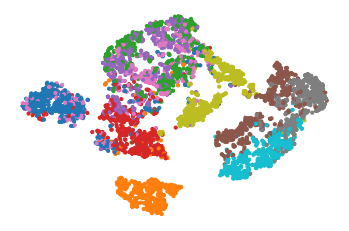

In [ ]:
np.random.seed(42)

from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis("off")
plt.show()


Saving figure fashion_mnist_visualization_plot


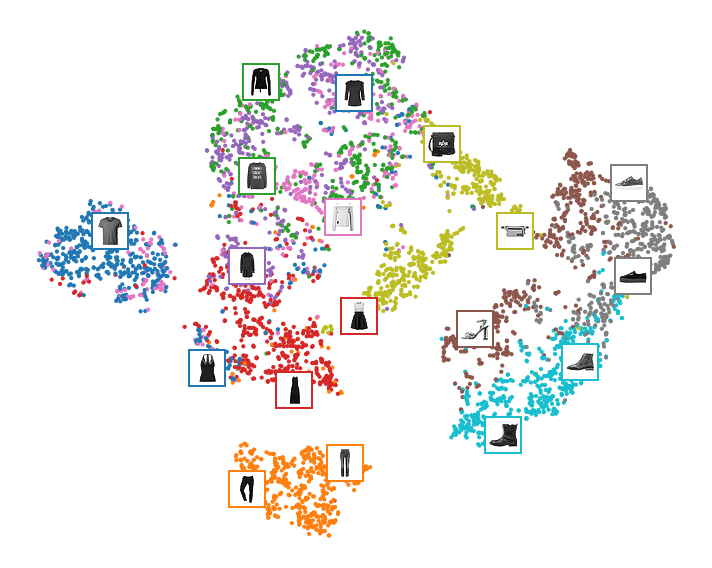

In [ ]:
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
save_fig("fashion_mnist_visualization_plot")
plt.show()

# Semantic Similarity Example - Text Data

In [ ]:
%%capture
# Seaborn is a Python data visualization library based on matplotlib. 
# It provides a high-level interface for drawing attractive and informative statistical graphics.
!pip3 install seaborn

In [ ]:
from absl import logging

import tensorflow as tf

import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [ ]:
def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=0.5)
  # increase size of heatmap boxes to make it easier to read
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      annot=True,
      linewidths=.5,
      cmap="YlOrRd", fmt='.3f')
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Similarity - Text")

def run_and_plot(text_):
  text_embeddings_ = embed(text_)
  # print embedding values
  print(text_embeddings_)
  plot_similarity(text_, text_embeddings_, 90)

tf.Tensor(
[[ 0.01444859 -0.00280342  0.06519022 ... -0.06811651 -0.00135644
  -0.04516896]
 [ 0.06006566  0.01471317 -0.08950374 ... -0.04052838  0.04429497
   0.05166151]
 [ 0.04317198  0.03057081 -0.02247836 ...  0.03068199  0.0729802
  -0.06222686]
 ...
 [-0.03128455  0.03810194  0.04330039 ...  0.0739837   0.08154897
   0.01774823]
 [-0.05128722 -0.01927151  0.00703915 ...  0.03181372  0.05671164
  -0.0481384 ]
 [-0.05744841 -0.07030954  0.03281313 ... -0.0413345   0.0125767
   0.02744546]], shape=(13, 512), dtype=float32)


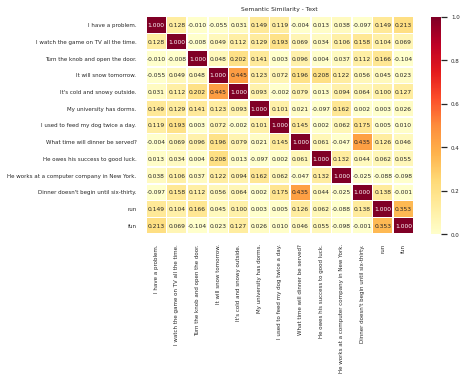

In [ ]:
# find similarity using random assortment of sentences
text = [
    "I have a problem.",
    "I watch the game on TV all the time.",
    "Turn the knob and open the door.",
    "It will snow tomorrow.",
    "It's cold and snowy outside.",
    "My university has dorms.",
    "I used to feed my dog twice a day.",
    "What time will dinner be served?",
    "He owes his success to good luck.",
    "He works at a computer company in New York.",
    "Dinner doesn't begin until six-thirty.",
    "run","fun",
]

run_and_plot(text)



---



# Text Embedding


In [ ]:
import io
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers import TextVectorization

In [ ]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1.tar.gz", url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
os.listdir(dataset_dir)

84140032/84125825 [==============================] - 6s 0us/step


['test', 'train', 'README', 'imdb.vocab', 'imdbEr.txt']

In [ ]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [ ]:
batch_size = 1024
seed = 123
train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', batch_size=batch_size, validation_split=0.2,
    subset='training', seed=seed)
val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', batch_size=batch_size, validation_split=0.2,
    subset='validation', seed=seed) 

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [ ]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(10):
    print(label_batch[i].numpy(), text_batch.numpy()[i])

0 b"Oh My God! Please, for the love of all that is holy, Do Not Watch This Movie! It it 82 minutes of my life I will never get back. Sure, I could have stopped watching half way through. But I thought it might get better. It Didn't. Anyone who actually enjoyed this movie is one seriously sick and twisted individual. No wonder us Australians/New Zealanders have a terrible reputation when it comes to making movies. Everything about this movie is horrible, from the acting to the editing. I don't even normally write reviews on here, but in this case I'll make an exception. I only wish someone had of warned me before I hired this catastrophe"
1 b'This movie is SOOOO funny!!! The acting is WONDERFUL, the Ramones are sexy, the jokes are subtle, and the plot is just what every high schooler dreams of doing to his/her school. I absolutely loved the soundtrack as well as the carefully placed cynicism. If you like monty python, You will love this film. This movie is a tad bit "grease"esk (without

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Embed a 1,000 word vocabulary in 5 dimensions.
embedding_layer = tf.keras.layers.Embedding(1000, 5)

In [ ]:
result = embedding_layer(tf.constant([1, 2, 3]))
result.numpy()

array([[ 0.0053376 , -0.00319856,  0.04272285,  0.02876255,  0.00410206],
       [-0.01859406,  0.02260221,  0.03131131, -0.037379  , -0.00861068],
       [ 0.02132312, -0.01656519, -0.02169221, -0.03836639, -0.01723015]],
      dtype=float32)

In [ ]:
result = embedding_layer(tf.constant([[0, 1, 2], [3, 4, 5]]))
result.shape

TensorShape([2, 3, 5])

In [ ]:
# Custom standardization.
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation), '')


vocab_size = 10000
sequence_length = 100

# Use the text vectorization layer to normalize
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
text_ds = train_ds.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)

In [ ]:
embedding_dim=16

model = Sequential([
  vectorize_layer,
  Embedding(vocab_size, embedding_dim, name="embedding"),
  GlobalAveragePooling1D(),
  Dense(16, activation='relu'),
  Dense(1)
])

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[tensorboard_callback])

model.summary()

Epoch 1/15
20/20 [==============================] - 8s 350ms/step - loss: 0.6921 - accuracy: 0.5028 - val_loss: 0.6901 - val_accuracy: 0.4886
Epoch 2/15
20/20 [==============================] - 2s 103ms/step - loss: 0.6881 - accuracy: 0.5028 - val_loss: 0.6847 - val_accuracy: 0.4886
Epoch 3/15
20/20 [==============================] - 2s 86ms/step - loss: 0.6812 - accuracy: 0.5028 - val_loss: 0.6761 - val_accuracy: 0.4886
Epoch 4/15
20/20 [==============================] - 2s 116ms/step - loss: 0.6705 - accuracy: 0.5028 - val_loss: 0.6634 - val_accuracy: 0.4886
Epoch 5/15
20/20 [==============================] - 2s 92ms/step - loss: 0.6549 - accuracy: 0.5041 - val_loss: 0.6462 - val_accuracy: 0.4944
Epoch 6/15
20/20 [==============================] - 2s 84ms/step - loss: 0.6326 - accuracy: 0.5362 - val_loss: 0.6222 - val_accuracy: 0.5528
Epoch 7/15
20/20 [==============================] - 2s 83ms/step - loss: 0.6041 - accuracy: 0.6130 - val_loss: 0.5948 - val_accuracy: 0.6232
Epoch 8/15

In [ ]:
weights = model.get_layer('embedding').get_weights()[0]
vocab = vectorize_layer.get_vocabulary()

out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocab):
  if index == 0:
    continue  
    
  vec = weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception:
  pass


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

To visualize the embeddings, upload them to the embedding projector.
http://projector.tensorflow.org/ 
* Click on "Load data" and Upload the two files from above: vecs.tsv and meta.tsv.

